# NN vs RF

## Comparing Neural Networks to Random Forests

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy
import time

# Sample Data

## Environment Canada Burns bog climate station

* Estimate RH from Ta & Tdew

* Test extrapolation capability by masking out RH > 95%

In [2]:
root_url = "Data/DELTA BURNS BOG.csv"
Data = pd.read_csv(root_url)
Data = (Data[['TEMP', 'DEW_POINT_TEMP','RELATIVE_HUMIDITY']].dropna())
# print(Data.shape)

X = Data[['TEMP', 'DEW_POINT_TEMP']].values
Y = Data['RELATIVE_HUMIDITY'].values.reshape(-1,1)

x_mask = Data.loc[Data['RELATIVE_HUMIDITY']>=95,['TEMP', 'DEW_POINT_TEMP']].values
x = Data.loc[Data['RELATIVE_HUMIDITY']<95,['TEMP', 'DEW_POINT_TEMP']].values
# x_test = X[0:1000,:]
# x_train = X[1000:,:]


y_mask = Data.loc[Data['RELATIVE_HUMIDITY']>=95,'RELATIVE_HUMIDITY'].values
y = Data.loc[Data['RELATIVE_HUMIDITY']<95,'RELATIVE_HUMIDITY'].values
# y_test = Y[0:1000]
# y_train = Y[1000:]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)

print('Training Samples: ',y_train.shape)
print('Testing Samples: ',y_test.shape)
print('Masked Samples: ',y_mask.shape)

Training Samples:  (36208,)
Testing Samples:  (4024,)
Masked Samples:  (26281,)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,14,18,20,22,28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Random Forest

* Simple to set up
* Training is very fast

In [3]:
T1 = time.time()

RF = RandomForestRegressor()
RF.fit(x_train, y_train)
T2 = time.time()
print('Training Time: ', np.round(T2 - T1,2),' Seconds')


Training Time:  3.29  Seconds


# Validation highlights extrapolation issue

Validation Metrics: testing Data 
r2 =  0.9992 
RMSE =  0.21
Validation Metrics: Masked Data 
r2 =  0.0 
RMSE =  20.55


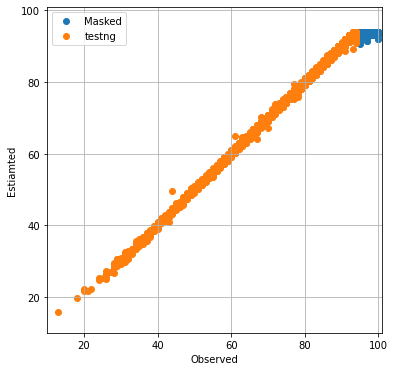

In [4]:
test = RF.predict(x_test)
Mask = RF.predict(x_mask)


R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

R2 = metrics.r2_score(y_mask,Mask)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_mask,Mask)
print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))


plt.figure(figsize=(6,6))
plt.scatter(y_mask,Mask,label='Masked')
plt.scatter(y_test,test,label='testng')
plt.ylabel('Estiamted')
plt.xlabel('Observed')
plt.xlim(10,101)
plt.ylim(10,101)
plt.grid()
plt.legend()
plt.show()

# Neural Network

* Not as simple to set up
* Training is slower
    * This is on a GPU - would be **much slower** on CPU
    * An ensemble of NNs is more stable than one NN


In [6]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Dense(
        64,
        activation='relu',
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros"
    )(input_layer)
    output_layer = keras.layers.Dense(1)(conv1)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

T0 = time.time()

N = 10

for i in range(0,N):
    T1 = time.time()
    model = make_model(input_shape=x_train.shape[1:])

    epochs = 250
    batch_size = 32

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "temp_files/best_model"+str(i)+".h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=0),
    ]

    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )

    T2 = time.time()
    print('Network #'+str(i))
    print('\nTraining Time: ', np.round(T2 - T1,2),' Seconds')
    print('')

# T2 = time.time()
print('\nFull Training Time: ', np.round(T2 - T0,2),' Seconds')

Epoch 00017: early stopping

Training Time:  40.75  Seconds
Epoch 00016: early stopping

Training Time:  27.58  Seconds
Epoch 00016: early stopping

Training Time:  39.36  Seconds
Epoch 00020: early stopping

Training Time:  106.05  Seconds
Epoch 00013: early stopping

Training Time:  67.66  Seconds
Epoch 00031: early stopping

Training Time:  58.46  Seconds
Epoch 00015: early stopping

Training Time:  26.44  Seconds
Epoch 00021: early stopping

Training Time:  54.8  Seconds
Epoch 00020: early stopping

Training Time:  69.39  Seconds
Epoch 00013: early stopping

Training Time:  24.43  Seconds
Epoch 00019: early stopping

Training Time:  56.52  Seconds
Epoch 00018: early stopping

Training Time:  34.26  Seconds
Epoch 00013: early stopping

Training Time:  27.01  Seconds
Epoch 00014: early stopping

Training Time:  27.6  Seconds
Epoch 00017: early stopping

Training Time:  32.97  Seconds
Epoch 00014: early stopping

Training Time:  35.88  Seconds
Epoch 00017: early stopping

Training Tim

: 

: 

# Validation

* The model is capable of making extrapolating

(4024, 1)
Validation Metrics: testing Data 
r2 =  0.9994 
RMSE =  0.16
Validation Metrics: Masked Data 
r2 =  0.3511 
RMSE =  1.9


<IPython.core.display.Javascript object>


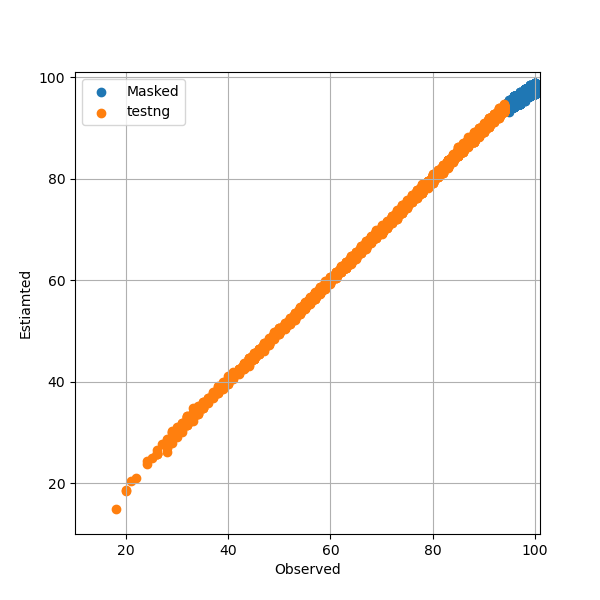

In [25]:
test = []
Mask = []

for i in range(0,N):
    model.load_weights("best_model"+str(i)+".h5")
    test.append(model.predict(x_test))
    Mask.append(model.predict(x_mask))

test = np.array(test).mean(axis=0)
Mask = np.array(Mask).mean(axis=0)

print(test.shape)

R2 = metrics.r2_score(y_test,test)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_test,test)
print('Validation Metrics: testing Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

R2 = metrics.r2_score(y_mask,Mask)
if R2 < 0:
    R2 = 0.0
RMSE = metrics.mean_squared_error(y_mask,Mask)
print('Validation Metrics: Masked Data \nr2 = ',np.round(R2,4),'\nRMSE = ',np.round(RMSE,2))

plt.figure(figsize=(6,6))
plt.scatter(y_mask,Mask,label='Masked')
plt.scatter(y_test,test,label='testing')
plt.ylabel('Estiamted')
plt.xlabel('Observed')
plt.xlim(10,101)
plt.ylim(10,101)
plt.grid()
plt.legend()
